# Combinatorics: Count non trivial dead graphs of Nest (example below)

In [19]:

import numpy as np
from numba.typed import Dict, List
from numba import njit
from anonymigraph.anonymization._external.nest_model.fast_rewire import create_neighborhood_dict, get_block_indices
from anonymigraph.anonymization._external.nest_model.fast_rewire import (
    get_block_indices,
    sort_edges,
)

def count_dead_subgraph(edges, colors):
    edges_ordered, edges_classes, dead_arr, is_mono = sort_edges(edges, colors, is_directed=False)
    block_indices = get_block_indices(edges_classes, dead_arr)

    old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = _count_dead_subgraph(
        edges_ordered,
        edges_classes[:, 0],
        is_mono[0],
        block_indices[0],
    )

    num_colors = np.unique(colors).size
    all_possible_color_subgraphs = num_colors * (num_colors + 1) // 2
    color_subgraphs_with_edges = np.unique(edges_classes[:, 0]).size

    return all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs

#@njit(cache=True)
def _count_dead_subgraph(edges, edge_class, is_mono_color, block):
    old_alive_total_subgraphs = 0
    true_additional_dead_subgraphs = 0
    old_additional_dead_subgraphs = 0

    for i in range(len(block)):
        lower = block[i, 0]
        upper = block[i, 1]
        current_class = edge_class[lower]
        block_edges = edges[lower:upper]

        if is_mono_color.get(current_class, False):
            any_swaps_possible = _is_there_any_edge_swap_possible_mono(block_edges)
        else:
            any_swaps_possible = _is_there_any_edge_swap_possible_bipartite(block_edges)

        if not any_swaps_possible:
            true_additional_dead_subgraphs += 1

        if np.unique(block_edges[:, 0]).size == 1 or np.unique(block_edges[:, 1]).size == 1:
            old_additional_dead_subgraphs += 1 # there

        old_alive_total_subgraphs += 1


    assert old_additional_dead_subgraphs <= 2 # this is a bug the last or first block is not correctly assigned as dead this should be 0 really

    return old_alive_total_subgraphs, true_additional_dead_subgraphs


@njit(cache=True)
def _is_there_any_edge_swap_possible_mono(edges):
    num_edges = len(edges)
    neigh = create_neighborhood_dict(edges)

    for index1 in range(num_edges):
        for index2 in range(num_edges):
            if index1 == index2:
                continue
            for i2_1 in range(2):
                i2_1 = np.random.randint(0, 2)
                i2_2 = 1 - i2_1
                e1_l, e1_r = edges[index1, :]
                e2_l = edges[index2, i2_1]
                e2_r = edges[index2, i2_2]

                if (e1_r == e2_r) or (e1_l == e2_l):  # swap would do nothing
                    continue

                if (e1_l == e2_r) or (e1_r == e2_l):  # no self loops after swap
                    continue

                if e2_r in neigh[e1_l] or e1_r in neigh[e2_l]:
                    # we cant swap
                    pass
                else:
                    # we can swap
                    return True
    # no swaps at all
    return False

@njit(cache=True)
def _is_there_any_edge_swap_possible_bipartite(edges):
    """Rewires a bipartite network specified in edges

    This is optimized for larger networks and uses a dictionary lookup to avoid multi edges
    """

    delta = len(edges)
    neigh = Dict()
    neigh[0] = List([-1])
    del neigh[0]
    for l, r in edges:
        if l not in neigh:
            tmp = List([-1])
            tmp.pop()
            neigh[l] = tmp
        neigh[l].append(r)

    for index1 in range(delta):
        for index2 in range(delta):
            if index1 == index2:
                continue
            e1_l, e1_r = edges[index1, :]
            e2_l, e2_r = edges[index2, :]

            if (e1_r == e2_r) or (e1_l == e2_l):  # swap would do nothing
                continue

            if (e1_l == e2_r) or (e1_r == e2_l):  # no self loops after swap
                continue

            if e2_r in neigh[e1_l] or e1_r in neigh[e2_l]:
                # we cant swap
                pass
            else:
                # we can swap
                return True
    # no swaps at all
    return False


possible color subgraphs: 3 of those non-empty: 1 of those are alive by org nest: 1 of those are additional dead: 1


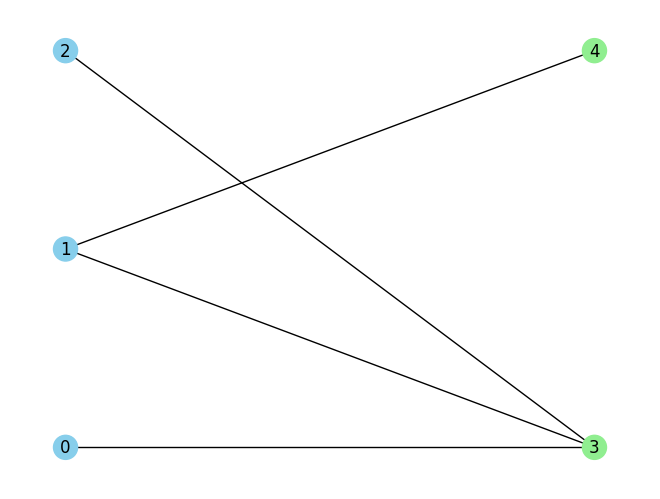

In [20]:
import networkx as nx
import numpy as np

G = nx.Graph()
G.add_nodes_from([0, 1, 2], bipartite=0)  # Group 1
G.add_nodes_from([3, 4], bipartite=1)    # Group 2
G.add_edges_from([(0, 3), (1, 3), (2, 3), (1, 4)])

colors = np.array([0,0,0,1,1])

edges = np.array(G.edges(), dtype=np.uint32)

all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = count_dead_subgraph(edges, colors.reshape(1, -1))
print(f"possible color subgraphs: {all_possible_color_subgraphs} of those non-empty: {color_subgraphs_with_edges} of those are alive by org nest: {old_alive_total_color_subgraphs} of those are additional dead: {true_additional_dead_color_subgraphs}")

pos = nx.bipartite_layout(G, [0,1,2])
nx.draw(G, pos, with_labels=True, node_color=['skyblue' if node in [0,1,2] else 'lightgreen' for node in G.nodes()])

# Define Graph Bound / Convergence tool for graphs

In [21]:
from scipy.sparse.linalg import eigsh

def UNSTABLE_LEGACY_largest_eigen(A, maxiter = None):

    val, evs = eigsh(A, k=1, which='LA', maxiter = maxiter)
    ev = evs[:, 0]

    # Find the first non-zero entry to determine the sign adjustment
    if np.sign(ev[ev != 0][0]) < 0:
        ev = -ev

    if not np.all(ev > 0):
        raise ValueError("The adjusted eigenvector does not have all positive entries.")

    return val[0], ev

def largest_eigen(A, num_iters=None, tol=None):
    if num_iters is None:
        num_iters = 10000
    if tol is None:
        tol = 1e-14

    n = A.shape[0]  # Size of the matrix
    vec = np.ones(n)  # Starting with a constant vector

    for _ in range(num_iters):
        vec_next = A @ vec + vec  # Adjusted iteration step
        norm = np.linalg.norm(vec_next)  # Compute the norm
        vec_diff = vec_next / norm - vec  # Compute difference for convergence check
        vec = vec_next / norm  # Update vector

        # Check for convergence
        if np.linalg.norm(vec_diff) < tol:
            break

    eigenvalue = (vec.T @ (A @ vec)) / (vec.T @ vec)  # Rayleigh quotient for eigenvalue

    if not np.all(vec > 0):
        raise ValueError("The adjusted eigenvector does not have all positive entries.")

    return eigenvalue, vec

def eigen_gap(A):
    val, _ = eigsh(A, k=2, which='LA')
    return val[1] - val[0]

def k_biggest_ev(A, k=1):
    val, _ = eigsh(A, k=k, which='LA')
    return val

def get_delta(A, lam, x):
    return A @ x - lam * x

def calculate_kmeans_cluster_loss(x, cluster_labels, centroids, mode=2):
    assert mode == 2
    total_loss = 0
    for i, color in enumerate(cluster_labels):
        centroid = centroids[color]
        distance = (x[i] - centroid) ** 2
        total_loss += distance
    return np.sqrt(total_loss)

In [22]:
from anonymigraph.anonymization._external.nest_model._rewire import _rewire
import optimal1dclustering

def get_convergence_data_of_nest(G, min_cluster_size = 1, printing = False, max_k = float("Inf"), max_iter=None, random_seed=44):
    if not nx.is_connected(G):
        raise ValueError("G is not connected, spectral gap may be 0 nothing holds anymore.")
    A_G = nx.adjacency_matrix(G).astype(np.float64)  # Get the adjacency matrix as a sparse matrix
    lam_G, x = largest_eigen(A_G, max_iter)
    _, max_degree = max(G.degree(), key=lambda pair: pair[1])
    spectral_gap = eigen_gap(A_G)

    print("Dominant eigenvalue:", lam_G)
    print("max_degree:", max_degree)
    print("spectral_gap", spectral_gap)

    data_dict = {}
    for k in range(1, min(G.number_of_nodes()//min_cluster_size, max_k)):
        results = {}
        mode = 2
        colors, centroids = optimal1dclustering.cluster(
            x, k, mode=mode, min_cluster_size=min_cluster_size
        )
        colors = np.array(colors)
        clusterLoss = calculate_kmeans_cluster_loss(x, colors, centroids, mode = mode)

        # Get new synthetic graph with Variation Nest
        edges = np.array(G.edges(), dtype=np.uint32)
        edges_rewired = _rewire(edges, colors.reshape(1, -1), r=10, parallel=False, random_seed=random_seed)
        Ga = nx.Graph()
        Ga.add_nodes_from(G.nodes(data=True))
        Ga.add_edges_from(edges_rewired)

        # dead subgraph statistics
        is_G_a_connected = int(nx.is_connected(Ga))
        all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = count_dead_subgraph(edges, colors.reshape(1, -1))

        # Get graph spectrum statistics
        A_Ga = nx.adjacency_matrix(Ga).astype(np.float64)
        delta = get_delta(A_Ga, lam_G, x)
        delta_norm = np.linalg.norm(delta)
        lam_Ga, x_Ga = largest_eigen(A_Ga)
        eigenvec_diff_norm = np.linalg.norm(x - x_Ga)

        #eigenvec_diff_norm_bound = 2*max_degree*clusterLoss / spectral_gap # provable approx upper bound
        eigenvec_diff_norm_bound = 2*lam_G*clusterLoss / spectral_gap # approx approx upper bound
        #eigenvec_diff_norm_bound = lam_G*clusterLoss / spectral_gap # probably approx uppper bound tight

        if eigenvec_diff_norm > eigenvec_diff_norm_bound and k > 150 and is_G_a_connected == 1:
            print("BREAKPOINT")
            print("BREAKPOINT")
            """
            graph = G
            import matplotlib.pyplot as plt
            plt.figure(dpi=300)
            cmap = plt.cm.get_cmap('hsv', k)
            pos = nx.circular_layout(graph)
            nx.draw(graph, pos, with_labels=False, font_size=8, node_size=7, node_color="white")
            for i, (node, color_class) in enumerate(zip(graph.nodes, colors)):
                plt.text(pos[node][0], pos[node][1], s=color_class, horizontalalignment='center', verticalalignment='center_baseline', fontdict={'color': 'black', 'size': 3})
            plt.show()
            """

        # Saving stats
        results['all_possible_color_subgraphs'] = all_possible_color_subgraphs
        results['color_subgraphs_with_edges'] = color_subgraphs_with_edges
        results['old_alive_total_color_subgraphs'] = old_alive_total_color_subgraphs
        results['true_additional_dead_color_subgraphs'] = true_additional_dead_color_subgraphs
        results['is_G_a_connected'] = is_G_a_connected

        results['Clustering Loss'] = clusterLoss
        results['Delta L2 Magnitude'] = delta_norm
        results['Delta L2 Magnitude / Lambda_G'] = delta_norm/lam_G
        results['Eigenvec L2 Norm Diff'] = eigenvec_diff_norm
        results['Eigenvec L2 Norm Diff Bound'] = eigenvec_diff_norm_bound
        results['Dominant Lambda Diff'] = lam_Ga - lam_G

        data_dict[k] = results

        if printing:
            print("-"*30)
            print(f"{k}: Clustering Loss", clusterLoss)
            print(f"{k}: possible color subgraphs: {all_possible_color_subgraphs} of those non-empty: {color_subgraphs_with_edges} of those are alive by org nest: {old_alive_total_color_subgraphs} of those are additional dead: {true_additional_dead_color_subgraphs}")

            print(f"{k}: Eigenvec L2 Norm Diff:", eigenvec_diff_norm)
            print(f"{k}: Eigenvec L2 Norm Diff Bound:", eigenvec_diff_norm_bound)
            print(f"{k}: Delta L2 Magnitude", delta_norm)
            print(f"{k}: Delta L2 Magnitude / Lambda_G", delta_norm/lam_G)
            print(f"{k}: Dominant Lambda Diff:", lam_Ga - lam_G)
            print(f"{k}: is_G_a_connected:", is_G_a_connected)
        else:
            print(k)

    return data_dict

import plotly.graph_objects as go

def plot_convergence_data(data_dict, title):

    # Create traces for each metric
    traces = []
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Clustering Loss'] for k in data_dict.keys()],
                                    mode='lines+markers',
                                    name='Clustering Loss'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                            y=[data_dict[k]['Delta L2 Magnitude'] for k in data_dict.keys()],
    #                            mode='lines+markers',
    #                            name='Delta L2 Magnitude'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                            y=[data_dict[k]['Delta L2 Magnitude / Lambda_G'] for k in data_dict.keys()],
    #                            mode='lines+markers',
    #                            name='Delta L2 Magnitude / Lambda_G'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                             y=[data_dict[k]['Dominant Lambda Diff'] for k in data_dict.keys()],
    #                             mode='lines+markers',
    #                             name='Dominant Lambda Diff'))
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Eigenvec L2 Norm Diff'] for k in data_dict.keys()],
                                    mode='lines+markers',
                                    name='Eigenvec L2 Norm Diff'))
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Eigenvec L2 Norm Diff Bound'] for k in data_dict.keys()],
                                    mode='lines+markers',
                                    name='Eigenvec L2 Norm Diff Bound'))

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['color_subgraphs_with_edges'] for k in data_dict.keys()],
                            mode='lines+markers',
                            name='Color Subgraphs with edges',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['old_alive_total_color_subgraphs'] for k in data_dict.keys()],
                            mode='lines+markers',
                            name='non-dead color subgraphs (as defined in original nest)',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['true_additional_dead_color_subgraphs'] for k in data_dict.keys()],
                            mode='lines+markers',
                            name='Additional dead color subgraphs',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['is_G_a_connected'] for k in data_dict.keys()],
                            mode='lines+markers',
                            name='1 if sampled graph is connected',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    layout_loglog = go.Layout(title=title,
                            xaxis_title='k',
                            yaxis_title='Metric Values (Log Scale)',
                            yaxis_type='log',  # Set y-axis to log scale
                            # Add a second y-axis to the layout
                            yaxis=dict(
                                exponentformat='e',  # Use scientific notation for the primary y-axis
                            ),
                            yaxis2=dict(title='Color Subgraph Count Metrics',
                                        titlefont=dict(color='rgba(148, 103, 189, 1)'),
                                        tickfont=dict(color='rgba(148, 103, 189, 1)'),
                                        overlaying='y',  # This places the second y-axis on top of the first
                                        side='right',  # This places the second y-axis on the right
                                        type='linear'),  # Set the second y-axis to linear scale
                            hovermode='closest',
                            height=900,
                            legend=dict(
                                    orientation="h",
                                    x=0.5,
                                    y=-0.1,
                                    xanchor="center",
                                    yanchor="top"
                                )
                            )

    # Add the new trace to the figure
    fig_loglog = go.Figure(data=traces, layout=layout_loglog)

    fig_loglog.show()


In [23]:
# Get a Graph
n = 400
tau1 = 3
tau2 = 1.5
mu = 0.1
G = nx.LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=10, min_community=80, seed=10
)
G.remove_edges_from(nx.selfloop_edges(G)) # some random graph

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, "LFR graph 400 Nodes (expo degree sequence)")

Dominant eigenvalue: 22.100950910040154
max_degree: 165
spectral_gap 6.381903406416557


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

# Erdos Renyis

In [ ]:
p = 0.05
G = nx.erdos_renyi_graph(150, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"erdos_renyi_graph with p={p}")

In [ ]:
p = 0.1
G = nx.erdos_renyi_graph(150, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"erdos_renyi_graph with p={p}")

In [ ]:
p = 0.25
G = nx.erdos_renyi_graph(150, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"erdos_renyi_graph with p={p}")

In [ ]:
p = 0.5
G = nx.erdos_renyi_graph(150, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"erdos_renyi_graph with p={p}")

In [ ]:
p = 0.95
G = nx.erdos_renyi_graph(150, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"erdos_renyi_graph with p={p}")

# Worst Case: Path Graphs
- almost certain that the cases where the bound is violated are numeric errors from clustering/power iteration, can't easily increase resolution either as optimalclustering works on floats no matter what

In [ ]:
n = 15  # Number of nodes for both graphs
G = nx.path_graph(n)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path Graph of length {n}")

In [ ]:
n = 30  # Number of nodes for both graphs
G = nx.path_graph(n)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path Graph of length {n}")

In [ ]:
n = 200  # Number of nodes for both graphs
G = nx.path_graph(n)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path Graph of length {n}")

In [ ]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=3)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_iter=1000000)
plot_convergence_data(data_dict, "Path Graph with 3 additional random edges")

In [ ]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=1)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_iter=1000000)
plot_convergence_data(data_dict, "Path Graph with 1 additional random edge")

In [ ]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=12)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

expected_path_edges = {(i, i+1) for i in range(n-1)} | {(i+1, i) for i in range(n-1)}  # Including both directions
actual_edges = set(G.edges())
non_path_edges = actual_edges - expected_path_edges
print(non_path_edges)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 200, max_iter = 10000000, random_seed=100)
plot_convergence_data(data_dict, "Path graph with two edges added - numeric instability from clustering/dom ev is likely")

In [ ]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=27)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100, max_iter = 10000000)
plot_convergence_data(data_dict, "Path graph with 5 edges added - numeric instability from clustering/dom ev is likely")



In [ ]:
n = 201  # n = 200 disaster
G = nx.path_graph(n)
G.add_edge(50, 150)
G.add_edge(95, 105)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 200, max_iter = 10000000, random_seed=333)
plot_convergence_data(data_dict, f"Path Graph of length {n} with instability edges (Likely numeric error of clustering/domev)")

# Tree Graphs (also difficult)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

r = 4
d = 5
n = r**d - 1
G = nx.full_rary_tree(r, n)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, f"Tree: {r}-children, {d}-depth")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

r = 2
d = 8
n = r**d - 1
G = nx.full_rary_tree(r, n)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, f"Tree: {r}-children, {d}-depth")

In [ ]:
r = 2
d = 8
n = r**d - 1
print(n)
avg_degree = r+1 # tree has degree = r+1
p_sparse = avg_degree/n*0.01
print("Expected noisy edges added:", n**2*p_sparse)
G = nx.compose(nx.erdos_renyi_graph(n, p_sparse), nx.full_rary_tree(r, n))

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 300)
plot_convergence_data(data_dict, f"Almost a Tree: {r}-children, {d}-depth Tree but with {p_sparse*100}% random edges added")

# d regular Graphs
- WL and EV is constant for exact d regular graphs. d regular graphs are however great expanders i.e. have a big spectral gap so bound should be good here.
- need to slightly pertub them

In [35]:
p = 109
expected_edges = 10
total_possible_edges = p * (p - 1) / 2
p_sparse = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

Gpaley = nx.paley_graph(p).to_undirected()
G = nx.compose(nx.erdos_renyi_graph(p, p_sparse, seed=57), Gpaley)
print(f"number of edges in Gpaley {Gpaley.number_of_edges()} number of edges added by noise {G.number_of_edges() - Gpaley.number_of_edges()}")

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, "d-Regular Graphs have a constant perron eigenvector still, this shows the upper bound works even here",)

number of edges in Gpaley 2943 number of edges added by noise 5
Dominant eigenvalue: 54.093293747645845
max_degree: 55
spectral_gap 48.76288585688839
------------------------------
1: Clustering Loss 0.005396385888851714
1: possible color subgraphs: 1 of those non-empty: 1 of those are alive by org nest: 1 of those are additional dead: 0
1: Eigenvec L2 Norm Diff: 0.0007290569473978676
1: Eigenvec L2 Norm Diff Bound: 0.011972559947252213
1: Delta L2 Magnitude 0.040653181437316034
1: Delta L2 Magnitude / Lambda_G 0.0007515382891448586
1: Dominant Lambda Diff: 1.3668692787405234e-05
1: is_G_a_connected: 1
------------------------------
2: Clustering Loss 0.0005157632877917367
2: possible color subgraphs: 3 of those non-empty: 3 of those are alive by org nest: 3 of those are additional dead: 0
2: Eigenvec L2 Norm Diff: 5.015989210688578e-05
2: Eigenvec L2 Norm Diff Bound: 0.0011442856402162206
2: Delta L2 Magnitude 0.002742738973474551
2: Delta L2 Magnitude / Lambda_G 5.0703863334147884e-0

In [ ]:
n = 400
d = 3
G = nx.random_regular_graph(d, n)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, eigsh_tol = )
plot_convergence_data(data_dict, "d-Regular Graphs have a constant perron eigenvector still, this shows the upper bound works even here")

# graphs to test
- reynold erneys
- power law graphs
- expander graphs 
- cliques
- trees and cliques that are d-regular
- graphs with large eigengap and ones with small
- real world graphs
- try to design a graph for which the number of alive sub colographs only sinks extremely slowly
- always test with different min_cluster sizes